# Kernel Density Estimation

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [104]:
df = pd.read_csv('aegypti.csv')

In [105]:
brazil_df = df[df["COUNTRY"] == "Brazil"]

In [106]:
brazil_df.head()
brazil_df.reset_index(drop = True, inplace = True)

In [107]:
brazil_df.head()

,VECTOR,OCCURRENCE_ID,SOURCE_TYPE,LOCATION_TYPE,POLYGON_ADMIN,Y,X,YEAR,COUNTRY,COUNTRY_ID,GAUL_AD0,STATUS
0,Aedes aegypti,402,unpublished,polygon,2,-32.21,-52.38,2013.0,Brazil,BRA,37,NaN
1,Aedes aegypti,403,unpublished,polygon,2,-31.56,-52.31,2013.0,Brazil,BRA,37,NaN
2,Aedes aegypti,404,unpublished,polygon,2,-30.80,-55.63,2013.0,Brazil,BRA,37,NaN
3,Aedes aegypti,405,unpublished,polygon,2,-30.37,-51.32,2013.0,Brazil,BRA,37,NaN
4,Aedes aegypti,406,unpublished,polygon,2,-30.34,-54.37,2013.0,Brazil,BRA,37,NaN


In [108]:
df_ = brazil_df.loc[:, ['Y','X','LOCATION_TYPE']]
df_['presence'] = 1

# Change sparsity fraction for different experiments

In [109]:
sparsity_fraction = 0.3
np.random.seed(42)
df_clone = df_.copy()

In [110]:

mask =  np.random.rand(df_.shape[0]) < sparsity_fraction

In [111]:
str_mask = [str(i) for i in mask]

In [112]:
df_clone['PRES'] = str_mask

In [113]:
def map_presence(val):
    if val == 'True':
        return np.nan
    elif val == 'False':
        return 1

In [114]:
df_clone['presence'] = df_clone['PRES'].apply(map_presence)


In [115]:
df_clone.head()

,Y,X,LOCATION_TYPE,presence,PRES
0,-32.21,-52.38,polygon,1.0,False
1,-31.56,-52.31,polygon,1.0,False
2,-30.80,-55.63,polygon,1.0,False
3,-30.37,-51.32,polygon,1.0,False
4,-30.34,-54.37,polygon,NaN,True


In [116]:
df_clone = df_clone.drop(columns = "PRES")

In [117]:
df_clone.head()

,Y,X,LOCATION_TYPE,presence
0,-32.21,-52.38,polygon,1.0
1,-31.56,-52.31,polygon,1.0
2,-30.80,-55.63,polygon,1.0
3,-30.37,-51.32,polygon,1.0
4,-30.34,-54.37,polygon,NaN


In [118]:
presence_data = df_clone[df_clone['presence'].notna()]
presence_data.reset_index(drop=True, inplace=True)

nodata = df_clone[df_clone['presence'].isnull()]
nodata.reset_index(drop=True, inplace=True)


In [119]:
presence_data.head()

,Y,X,LOCATION_TYPE,presence
0,-32.21,-52.38,polygon,1.0
1,-31.56,-52.31,polygon,1.0
2,-30.80,-55.63,polygon,1.0
3,-30.37,-51.32,polygon,1.0
4,-30.17,-51.44,polygon,1.0


In [120]:
nodata.head()

,Y,X,LOCATION_TYPE,presence
0,-30.34,-54.37,polygon,NaN
1,-30.29,-56.16,polygon,NaN
2,-30.21,-50.87,polygon,NaN
3,-30.00,-51.06,polygon,NaN
4,-29.89,-50.96,polygon,NaN


# Fitting a KDE

In [121]:
from scipy.stats import gaussian_kde

In [122]:
coords = presence_data[["X", "Y"]].values.T

In [123]:
import seaborn as sns

C:\Users\dzaik\AppData\Local\Temp\ipykernel_38244\616451087.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coords)


<Axes: ylabel='Density'>

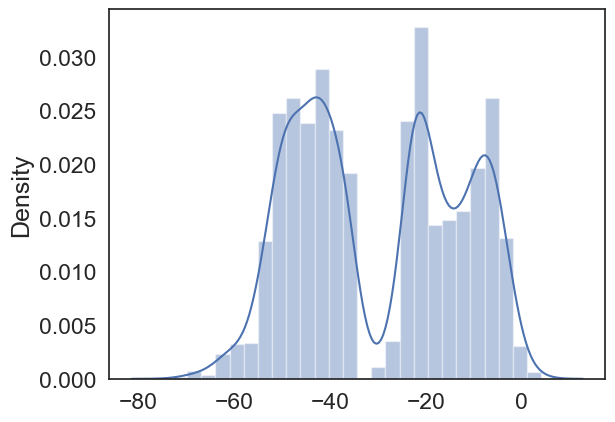

In [124]:
sns.distplot(coords)

In [125]:
X = presence_data[["X", "Y"]].values.T
sns.histplot             

<function seaborn.distributions.histplot(data=None, *, x=None, y=None, hue=None, weights=None, stat='count', bins='auto', binwidth=None, binrange=None, discrete=None, cumulative=False, common_bins=True, common_norm=True, multiple='layer', element='bars', fill=True, shrink=1, kde=False, kde_kws=None, line_kws=None, thresh=0, pthresh=None, pmax=None, cbar=False, cbar_ax=None, cbar_kws=None, palette=None, hue_order=None, hue_norm=None, color=None, log_scale=None, legend=True, ax=None, **kwargs)>

In [126]:
kde = gaussian_kde(coords, bw_method='scott')

In [127]:
from sklearn.neighbors import KernelDensity

In [128]:
nodata_coords = nodata[["X", "Y"]].values.T
nodata["kde_prediction"] = kde(nodata_coords)

C:\Users\dzaik\AppData\Local\Temp\ipykernel_38244\201832893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodata["kde_prediction"] = kde(nodata_coords)


# Prediction Visualization

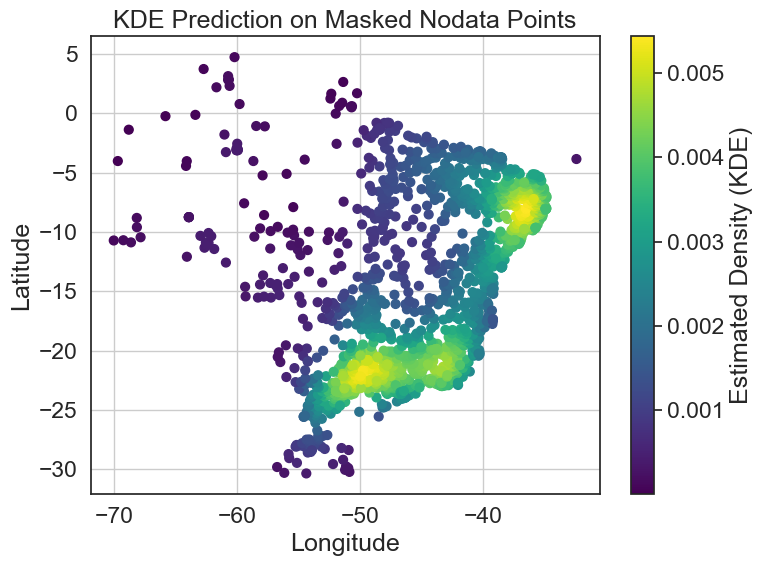

In [129]:
plt.figure(figsize=(8, 6))
plt.scatter(
    nodata["X"],
    nodata["Y"],
    c=nodata["kde_prediction"],
    cmap="viridis",
    s=40
)
plt.colorbar(label="Estimated Density (KDE)")
plt.title("KDE Prediction on Masked Nodata Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# AVERAGE MSE

In [130]:
import numpy as np

def kde_mse_estimate(f_hat, h, n):
    """
    Compute KDE MSE at each point using theoretical approximation.
    
    Args:
        f_hat (np.array): KDE density estimates at test points
        h (float): bandwidth
        n (int): number of training samples used in KDE

    Returns:
        np.array: MSE estimates at each point
    """
    R_K = 1 / (2 * np.sqrt(np.pi))  
    mu2_K = 1                       
    var = (1 / (n * h)) * R_K * f_hat
    bias_sq = (h ** 4 / 4) * (f_hat ** 2) * (mu2_K ** 2)
    return var + bias_sq
        

In [131]:
best_bandwidth = kde.factor * coords.std(axis=1).mean()


In [132]:

f_hat = nodata["kde_prediction"].values
n = len(nodata)

mse_per_point = kde_mse_estimate(f_hat, best_bandwidth, n)
average_mse = np.mean(mse_per_point)

print(f"Average KDE MSE over nodata points: {average_mse:.6f}")


Average KDE MSE over nodata points: 0.000027


In [133]:
from scipy.stats import gaussian_kde


presence_coords = presence_data[["X", "Y"]].values.T
n = presence_coords.shape[1]


kde = gaussian_kde(presence_coords, bw_method='scott')
h = kde.factor * presence_coords.std(axis=1).mean()


nodata_coords = nodata[["X", "Y"]].values.T
f_hat = kde(nodata_coords)


mse = kde_mse_estimate(f_hat, h, n)
print("Average KDE MSE:", np.mean(mse))


Average KDE MSE: 2.6945890994514978e-05


# CONTOUR PLOT

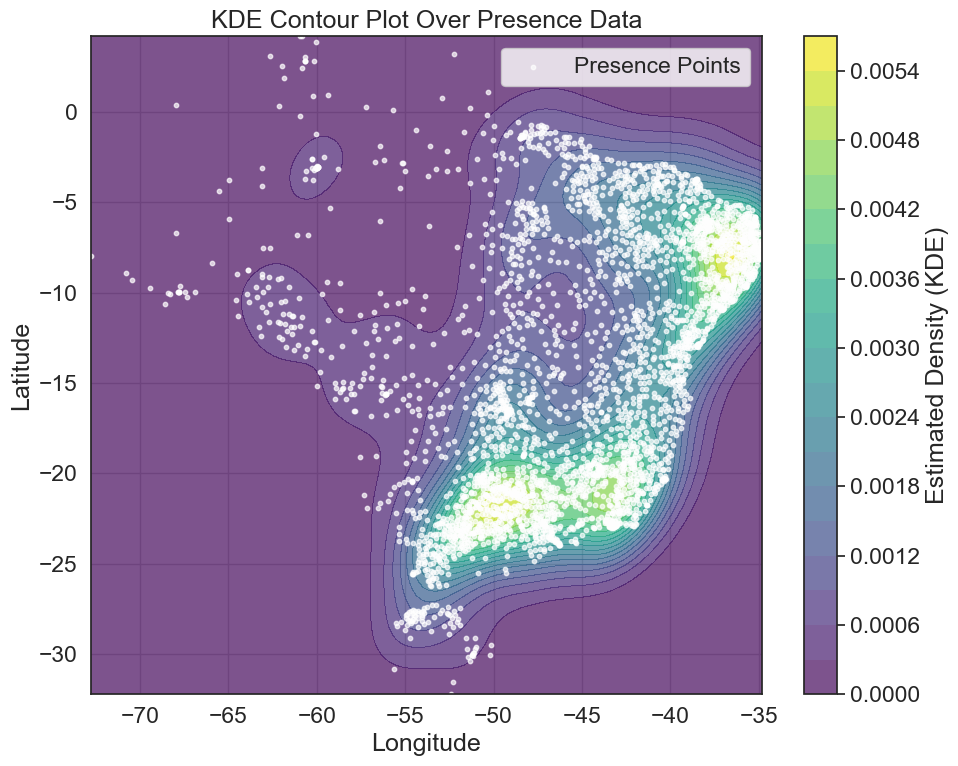

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


coords = presence_data[["X", "Y"]].values.T


kde = gaussian_kde(coords, bw_method='scott')


x_min, x_max = presence_data["X"].min(), presence_data["X"].max()
y_min, y_max = presence_data["Y"].min(), presence_data["Y"].max()

x, y = np.meshgrid(np.linspace(x_min, x_max, 100),
                   np.linspace(y_min, y_max, 100))
grid_coords = np.vstack([x.ravel(), y.ravel()])


z = kde(grid_coords).reshape(x.shape)


plt.figure(figsize=(10, 8))
contour = plt.contourf(x, y, z, levels=20, cmap="viridis", alpha=0.7)
plt.scatter(presence_data["X"], presence_data["Y"], c="white", s=10, label="Presence Points", alpha=0.7)
plt.colorbar(contour, label="Estimated Density (KDE)")
plt.title("KDE Contour Plot Over Presence Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [135]:
len(presence_data)
len(nodata)

1545

# CONTOUR PLOT

C:\Users\dzaik\AppData\Local\Temp\ipykernel_38244\3995908914.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodata["kde_prediction"] = kde(nodata_coords)


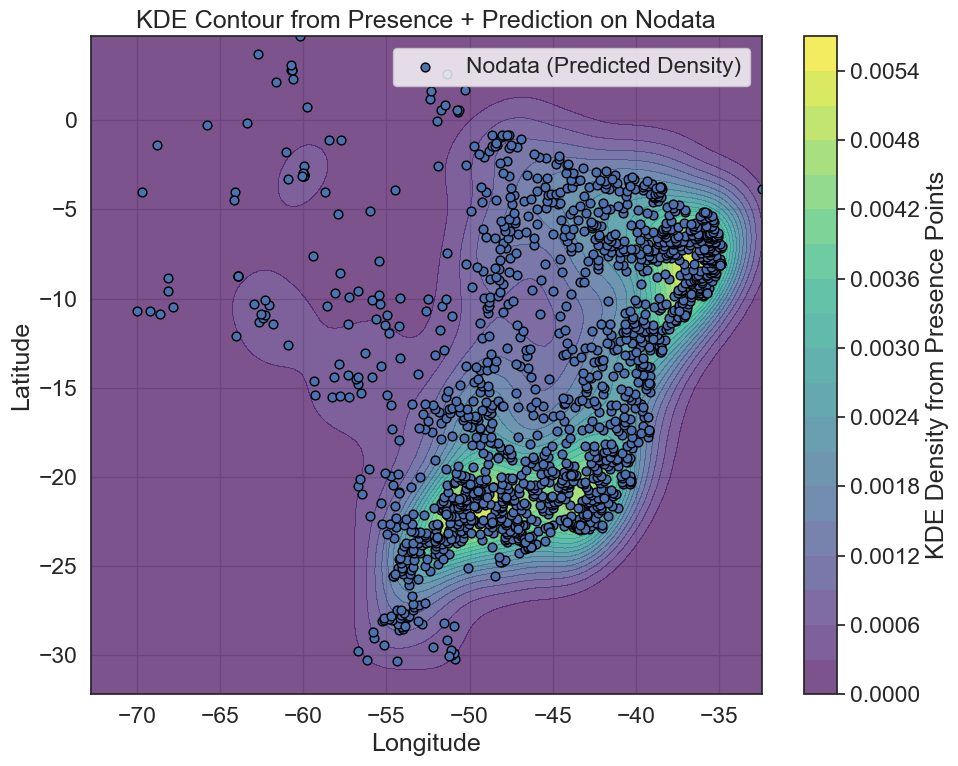

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


coords = presence_data[["X", "Y"]].values.T  
kde = gaussian_kde(coords, bw_method='scott')


x_min = min(presence_data["X"].min(), nodata["X"].min())
x_max = max(presence_data["X"].max(), nodata["X"].max())
y_min = min(presence_data["Y"].min(), nodata["Y"].min())
y_max = max(presence_data["Y"].max(), nodata["Y"].max())

x, y = np.meshgrid(np.linspace(x_min, x_max, 100),
                   np.linspace(y_min, y_max, 100))
grid_coords = np.vstack([x.ravel(), y.ravel()])
z = kde(grid_coords).reshape(x.shape)


nodata_coords = nodata[["X", "Y"]].values.T
nodata["kde_prediction"] = kde(nodata_coords)


plt.figure(figsize=(10, 8))
contour = plt.contourf(x, y, z, levels=20, cmap="viridis", alpha=0.7)
plt.colorbar(contour, label="KDE Density from Presence Points")


plt.scatter(nodata["X"], nodata["Y"],
            edgecolor='black', s=40, label="Nodata (Predicted Density)")

plt.title("KDE Contour from Presence + Prediction on Nodata")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BOYCE INDEX

In [137]:
import numpy as np

def boyce_index(pred_presence, pred_background, num_bins=10):
    """
    Compute the continuous Boyce Index.

    Args:
        pred_presence: KDE predictions at true presence locations
        pred_background: KDE predictions at nodata/background locations
        num_bins: number of bins to group predicted values

    Returns:
        Boyce Index value (Spearman correlation)
    """
    
    bins = np.linspace(pred_background.min(), pred_background.max(), num_bins + 1)

    
    pres_counts, _ = np.histogram(pred_presence, bins=bins)
    back_counts, _ = np.histogram(pred_background, bins=bins)

    
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = pres_counts / back_counts
        ratio = ratio[back_counts > 0]  
        bin_ranks = np.arange(len(ratio))

    
    if len(ratio) >= 2:
        return np.corrcoef(bin_ranks, ratio)[0, 1]
    else:
        return np.nan


In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
pseudo_df = pd.read_csv("pseudo_data.csv")

In [140]:
background_df = pseudo_df[pseudo_df['LOCATION_TYPE'] == 'absense']
background_df.reset_index(drop=True, inplace=True)

In [141]:

presence_coords = presence_data[["X", "Y"]].values.T
bkg_coords = background_df[["X", "Y"]].values.T

pred_presence = kde(presence_coords)
pred_background = kde(nodata_coords)


boyce = boyce_index(pred_presence, pred_background)
print(f"Boyce Index (KDE): {boyce:.4f}")


Boyce Index (KDE): 0.3022


# Covariates

In [142]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr

import earthpy as et


sns.set(font_scale=1.5, style="white")

In [143]:
import rasterio

raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    print(src.crs)


None


In [144]:
from rasterio.crs import CRS
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    df_clone,
    geometry=gpd.points_from_xy(df_clone['X'], df_clone['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["water_occurrence"] = values


In [145]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence"]].shape)


GeoDataFrame CRS: EPSG:4326
(5057, 3)


In [146]:
gdf.head()

,Y,X,LOCATION_TYPE,presence,geometry,water_occurrence
0,-32.21,-52.38,polygon,1.0,POINT (-52.38 -32.21),16.0
1,-31.56,-52.31,polygon,1.0,POINT (-52.31 -31.56),28.0
2,-30.80,-55.63,polygon,1.0,POINT (-55.63 -30.8),3.0
3,-30.37,-51.32,polygon,1.0,POINT (-51.32 -30.37),62.0
4,-30.34,-54.37,polygon,NaN,POINT (-54.37 -30.34),16.0


In [147]:
brazil_data_with_water = pd.DataFrame(gdf.drop(columns="geometry"))
print(brazil_data_with_water.head())

       Y      X LOCATION_TYPE  presence  water_occurrence
0 -32.21 -52.38       polygon       1.0              16.0
1 -31.56 -52.31       polygon       1.0              28.0
2 -30.80 -55.63       polygon       1.0               3.0
3 -30.37 -51.32       polygon       1.0              62.0
4 -30.34 -54.37       polygon       NaN              16.0


In [148]:
brazil_data_with_water.shape

(5057, 5)

In [149]:

gdf = gpd.GeoDataFrame(
    brazil_data_with_water,
    geometry=gpd.points_from_xy(brazil_data_with_water['X'], brazil_data_with_water['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_annual_mean_temp_2020_crop_mask.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["annual_mean_temp"] = values

In [150]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence", "annual_mean_temp"]].head())


GeoDataFrame CRS: EPSG:4326
       X      Y  water_occurrence  annual_mean_temp
0 -52.38 -32.21              16.0         18.891666
1 -52.31 -31.56              28.0         18.703333
2 -55.63 -30.80               3.0         18.783333
3 -51.32 -30.37              62.0         19.741667
4 -54.37 -30.34              16.0         19.441666


In [151]:
new_brazil_data = pd.DataFrame(gdf.drop(columns="geometry"))

In [152]:
new_brazil_data.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp
0,-32.21,-52.38,polygon,1.0,16.0,18.891666
1,-31.56,-52.31,polygon,1.0,28.0,18.703333
2,-30.80,-55.63,polygon,1.0,3.0,18.783333
3,-30.37,-51.32,polygon,1.0,62.0,19.741667
4,-30.34,-54.37,polygon,NaN,16.0,19.441666


In [153]:
def extract_raster_values(df, raster_path, column_name, x_col='X', y_col='Y', crs_epsg=4326):
    """
    Extracts raster values at each point location from a DataFrame and adds them as a new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with coordinate columns.
    - raster_path (str): Path to the raster file (.asc).
    - column_name (str): Name of the new column to add with extracted values.
    - x_col (str): Name of the longitude column.
    - y_col (str): Name of the latitude column.
    - crs_epsg (int): EPSG code of the coordinate reference system (default: 4326).

    Returns:
    - pd.DataFrame: DataFrame with the new column added.
    """
    
    # Converting DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[x_col], df[y_col]),
        crs=f"EPSG:{crs_epsg}"
    )
    
    # Opening the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs if src.crs is not None else CRS.from_epsg(crs_epsg)
        gdf = gdf.to_crs(raster_crs)
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    
    # Adding the extracted raster values as a new column
    gdf[column_name] = values
    
    # Returning as a regular DataFrame
    return pd.DataFrame(gdf.drop(columns="geometry"))


In [154]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_urban_built_up_earthenv.asc"
brazil_data_with_eath = extract_raster_values(new_brazil_data, raster_path, "urban_built_up_eartnev")


brazil_data_with_eath[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev"]].head()


,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev
0,-52.38,-32.21,16.0,18.891666,0.0
1,-52.31,-31.56,28.0,18.703333,0.0
2,-55.63,-30.80,3.0,18.783333,0.0
3,-51.32,-30.37,62.0,19.741667,0.0
4,-54.37,-30.34,16.0,19.441666,0.0


In [155]:
brazil_data_with_eath.shape

(5057, 7)

In [156]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_Croplands_2019.asc"
brazil_data_with_crop = extract_raster_values(brazil_data_with_eath, raster_path, "croplands")

brazil_data_with_crop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands
0,-52.38,-32.21,16.0,18.891666,0.0,0.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0


In [157]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_pop_density_2020.asc"
brazil_data_with_pop = extract_raster_values(brazil_data_with_crop, raster_path, "pop_density")


brazil_data_with_pop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853


In [158]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_elevation_crop_mask.asc"
brazil_data_with_crop_mask = extract_raster_values(brazil_data_with_pop, raster_path, "crop_mask")


brazil_data_with_crop_mask[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0


In [159]:
brazil_data_with_crop_mask.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-32.21,-52.38,polygon,1.0,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-31.56,-52.31,polygon,1.0,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-30.80,-55.63,polygon,1.0,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-30.37,-51.32,polygon,1.0,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-30.34,-54.37,polygon,NaN,16.0,19.441666,0.0,9.0,2.771853,102.0


In [160]:
new_brazil_data_cov = pd.DataFrame(gdf.drop(columns="geometry"))

In [161]:

new_brazil_data_cov.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp
0,-32.21,-52.38,polygon,1.0,16.0,18.891666
1,-31.56,-52.31,polygon,1.0,28.0,18.703333
2,-30.80,-55.63,polygon,1.0,3.0,18.783333
3,-30.37,-51.32,polygon,1.0,62.0,19.741667
4,-30.34,-54.37,polygon,NaN,16.0,19.441666


In [162]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_precipitation_mean_2023_crop_mask.asc"
brazil_data_with_precip = extract_raster_values(brazil_data_with_crop_mask, raster_path, "precipitation_mean")

brazil_data_with_precip[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask", "precipitation_mean"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [163]:
brazil_data_with_precip.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,1.0,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-31.56,-52.31,polygon,1.0,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-30.34,-54.37,polygon,NaN,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [164]:
presence_data = brazil_data_with_precip[brazil_data_with_precip["presence"].notna()]
nodata = brazil_data_with_precip[brazil_data_with_precip["presence"].isna()]


In [165]:
nodata = brazil_data_with_precip[brazil_data_with_precip["presence"].isna()]

# REGRESSION KDE

In [166]:
presence_data.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-32.21,-52.38,polygon,1.0,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-31.56,-52.31,polygon,1.0,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-30.80,-55.63,polygon,1.0,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-30.37,-51.32,polygon,1.0,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
7,-30.17,-51.44,polygon,1.0,52.0,19.913334,0.0,15.0,3.718940,62.0,4.120785


In [167]:
presence_data_cov = presence_data.copy()

In [168]:
presence_data.shape

(3512, 11)

In [169]:
coords_presence = presence_data[["X", "Y"]].values

In [170]:
from sklearn.neighbors import KernelDensity

# Fitting KDE on residuals

In [171]:
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(coords_presence)

KernelDensity(bandwidth=0.5)

In [172]:
log_density_presence = kde.score_samples(coords_presence)
density_presence = np.exp(log_density_presence)

In [173]:
presence_data_cov = presence_data.copy()
presence_data_cov["density_label"] = density_presence

In [174]:
features = ["water_occurrence","pop_density", "precipitation_mean"]

X = presence_data_cov[features].values
y = presence_data_cov["density_label"].values

In [175]:
from sklearn.model_selection import train_test_split

In [176]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [177]:
from sklearn.ensemble import RandomForestRegressor

In [178]:
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [179]:
y_val_pred = regressor.predict(X_val)

In [180]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [182]:
from sklearn.metrics import r2_score
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation R2: {r2_val:.3f}")

Validation R2: 0.401


In [183]:
nodata.head()

,Y,X,LOCATION_TYPE,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
4,-30.34,-54.37,polygon,NaN,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323
5,-30.29,-56.16,polygon,NaN,0.0,19.674999,0.0,0.0,0.169102,199.0,4.302065
6,-30.21,-50.87,polygon,NaN,0.0,19.891666,0.0,3.0,1.521041,45.0,4.435313
10,-30.00,-51.06,polygon,NaN,0.0,20.870001,35.0,2.0,7407.009766,10.0,4.409069
13,-29.89,-50.96,polygon,NaN,36.0,19.725000,0.0,0.0,60.650951,79.0,4.607059


In [184]:
nodata_cov = nodata.copy()

In [ ]:
X_nodata = nodata_cov[features].values
density_prediction_nodata = regressor.predict(X_nodata)
nodata_cov["regression_kde_prediction"] = density_prediction_nodata

# Prediction Visualization

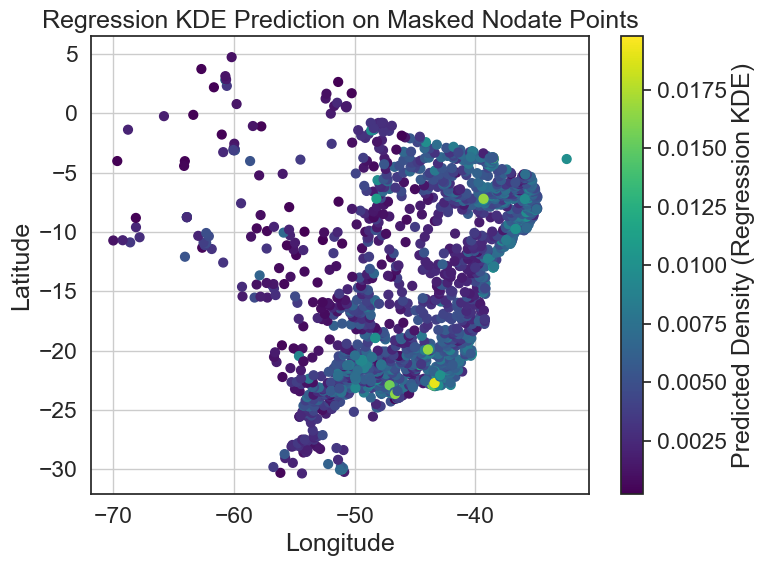

In [186]:
plt.figure(figsize=(8, 6))
plt.scatter(nodata_cov["X"], nodata_cov["Y"], 
            c=nodata_cov["regression_kde_prediction"], cmap="viridis", s=40)
plt.colorbar(label="Predicted Density (Regression KDE)")
plt.title("Regression KDE Prediction on Masked Nodate Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()

# Contour Plot

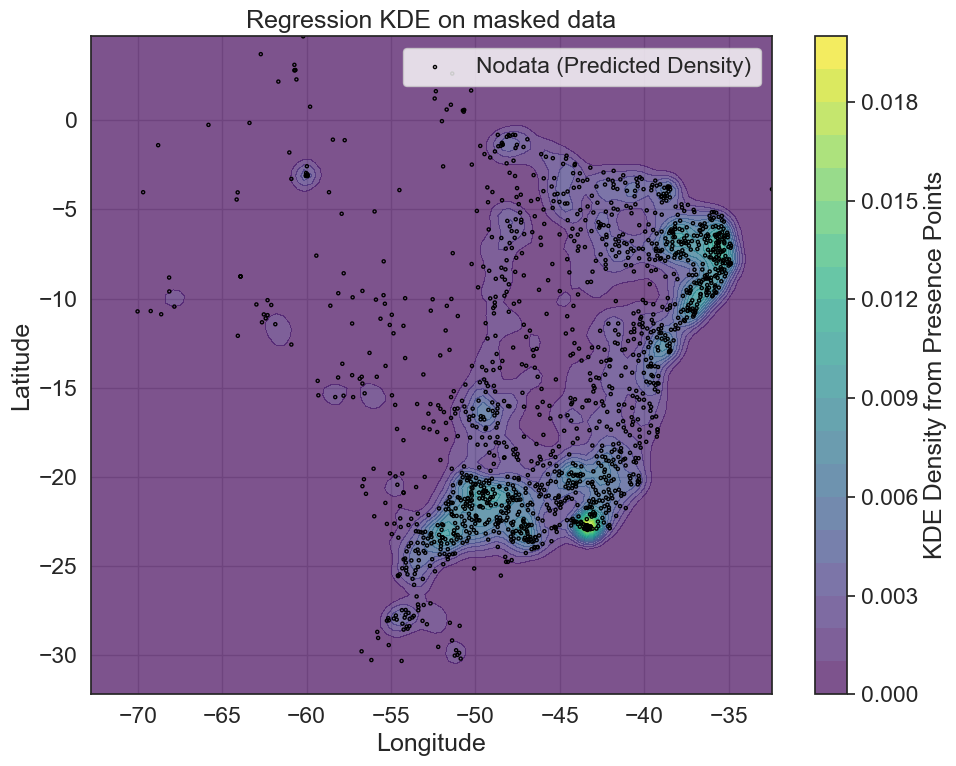

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Determine grid bounds from both presence and nodata
x_min = min(presence_data_cov["X"].min(), nodata_cov["X"].min())
x_max = max(presence_data_cov["X"].max(), nodata_cov["X"].max())
y_min = min(presence_data_cov["Y"].min(), nodata_cov["Y"].min())
y_max = max(presence_data_cov["Y"].max(), nodata_cov["Y"].max())

# Create meshgrid for contour plot
x, y = np.meshgrid(np.linspace(x_min, x_max, 100),
                   np.linspace(y_min, y_max, 100))
grid_coords = np.vstack([x.ravel(), y.ravel()]).T 

# Evaluate KDE on the grid using log density
log_dens = kde.score_samples(grid_coords) 
z = np.exp(log_dens).reshape(x.shape)

# Predict density at nodata coordinates
nodata_coords = nodata_cov[["X", "Y"]].values
log_dens_nodata = kde.score_samples(nodata_coords)
nodata_cov["kde_prediction"] = np.exp(log_dens_nodata)

# Plot the contour and nodata prediction overlay
plt.figure(figsize=(10, 8))
contour = plt.contourf(x, y, z, levels=20, cmap="viridis", alpha=0.7)
plt.colorbar(contour, label="KDE Density from Presence Points")

# Overlay nodata points with predicted densities
plt.scatter(nodata_cov["X"], nodata_cov["Y"],
            edgecolor='black', facecolor='none', s=5, label="Nodata (Predicted Density)")

plt.title("Regression KDE on masked data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# AVERAGE MSE

In [188]:
import numpy as np

def kde_mse_estimate(f_hat, h, n):
    """
    Compute KDE MSE at each point using theoretical approximation.
    
    Args:
        f_hat (np.array): KDE density estimates at test points
        h (float): bandwidth
        n (int): number of training samples used in KDE

    Returns:
        np.array: MSE estimates at each point
    """
    R_K = 1 / (2 * np.sqrt(np.pi))  
    mu2_K = 1                       
    var = (1 / (n * h)) * R_K * f_hat
    bias_sq = (h ** 4 / 4) * (f_hat ** 2) * (mu2_K ** 2)
    return var + bias_sq


best_bandwidth = kde.bandwidth_

f_hat = nodata_cov["regression_kde_prediction"].values
n = len(nodata_cov)

mse_per_point = kde_mse_estimate(f_hat, best_bandwidth, n)
average_mse = np.mean(mse_per_point)

print(f"Average KDE MSE over nodata points: {average_mse:.6f}")

Average KDE MSE over nodata points: 0.000002


# BOYCE INDEX

In [189]:
nodata_cov["regression_kde_prediction"].values

array([0.00231389, 0.00056158, 0.0018565 , ..., 0.00550969, 0.00132666,
       0.00330808], shape=(1545,))

Boyce Index: 0.7818


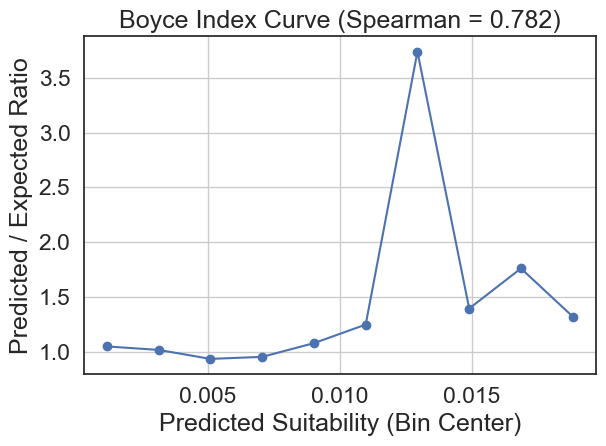

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Predict on presence covariates
presence_covariates = presence_data[features].values
presence_predictions = regressor.predict(presence_covariates)

# Get all predictions from background
all_predictions = nodata_cov["regression_kde_prediction"].values

# Define bins
nbin = 10
bins = np.linspace(min(all_predictions), max(all_predictions), nbin + 1)

# Bin the predictions
presence_binned = np.digitize(presence_predictions, bins) - 1
all_binned = np.digitize(all_predictions, bins) - 1

# Compute observed and expected frequencies
observed_freq = np.zeros(nbin)
expected_freq = np.zeros(nbin)

for i in range(nbin):
    observed_freq[i] = np.sum(presence_binned == i) / len(presence_binned)
    expected_freq[i] = np.sum(all_binned == i) / len(all_binned)

# Compute P/E ratio
with np.errstate(divide='ignore', invalid='ignore'):
    pe_ratio = observed_freq / expected_freq
    pe_ratio = np.where(expected_freq == 0, np.nan, pe_ratio)

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Filter valid bins and compute Boyce Index
valid = ~np.isnan(pe_ratio)
boyce_index = spearmanr(bin_centers[valid], pe_ratio[valid])[0]

# Plot
print(f"Boyce Index: {boyce_index:.4f}")
plt.plot(bin_centers[valid], pe_ratio[valid], marker='o')
plt.xlabel("Predicted Suitability (Bin Center)")
plt.ylabel("Predicted / Expected Ratio")
plt.title(f"Boyce Index Curve (Spearman = {boyce_index:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()


____